## Sample1 : Plot tweets on a map

### For projecting tweets on a map, install BaseMap + dependencies
http://matplotlib.org/basemap/users/installing.html
http://gnperdue.github.io/yak-shaving/osx/python/matplotlib/2014/05/01/basemap-toolkit.html

1. Proj4
2. Geos

In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from IPython import display


def get_twitter_data(csv_fname):  # Open csv file
    #     print('reading data')
    with open(csv_fname, 'r') as f:
        csvreader = csv.reader(f)
        for line in csvreader:
            yield line


def get_xy(array_iter):  # Get array holding user location info
    #     print('getting location of tweet')
    for i, arr in enumerate(array_iter):
        yield arr[3], arr[4], arr[2]


def plot_on_map(array_iter):
    count_tweets = 0
    twittermap = create_map()

    for i, arr in enumerate(array_iter):
        if i > 0:  # Skip header row
            count_tweets += 1
            x, y = twittermap(np.float(arr[0]), np.float(arr[1]))
            twittermap.plot(x, y, 'ro', markersize=5, alpha=0.5)
            plt.title('Tweet arrived from: {}'.format(arr[2]))


In [2]:
from mpl_toolkits.basemap import Basemap


def create_map():
    # plot the blank world map
    my_map = Basemap(projection='merc', lat_0=50, lon_0=-100,
                     resolution='l', area_thresh=5000.0,
                     llcrnrlon=-140, llcrnrlat=-55,
                     urcrnrlon=160, urcrnrlat=70)

    # draw elements onto the world map
    my_map.drawcountries()
    my_map.drawcoastlines(antialiased=False,
                          linewidth=0.005)

    return my_map

In [3]:
filename = "twitterfeed.csv"
itertweet = iter(get_twitter_data(filename))
headerrows = next(itertweet)  # First row is header
print(headerrows)

['Tweet', 'Hashtag', 'UserLocation', 'LocationX', 'LocationY', 'DateCreated', 'NumberofRetweets']


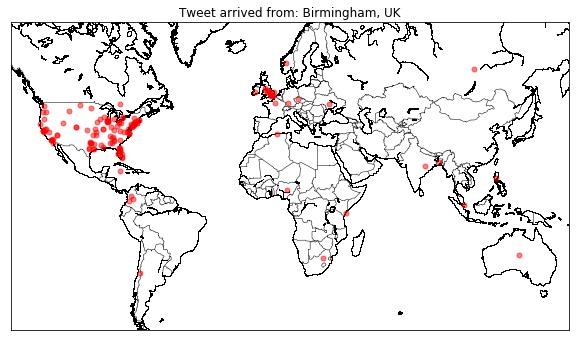

In [17]:
import time
closetime = time.time() + 60 #Run loop for 60 seconds

while time.time()<closetime:
    figurehandle = plt.figure(figsize=(10, 10))
    plot_on_map(get_xy(get_twitter_data(filename)))  # Call generator function
    
    #Refresh the plot
    plt.draw()
    display.clear_output(wait=True)
    display.display(plt.gcf())
    plt.close()

### Sample 2 : Sentiment analysis

In [6]:
import csv
from textblob import TextBlob


def get_twitter_data(csv_fname):  # Open csv file
    #     print('reading data')
    with open(csv_fname, 'r') as f:
        csvreader = csv.reader(f)
        for line in csvreader:
            yield line


def get_text(array_iter):  # Get array holding user location info
    #     print('getting location of tweet')
    for i, arr in enumerate(array_iter):
        yield arr[0]


def get_tweet_sentiment(array_iter):
    data_set = {keys: [] for keys in ['text', 'Sentiment', 'SentimentClass']}
    for i, arr in enumerate(array_iter):
        if i > 0:  # Skip header row
            textB = TextBlob(arr)
            sentiment = textB.sentiment.polarity
            data_set['text'].append(str(textB))
            data_set['Sentiment'].append(sentiment)
            if sentiment < 0.00:
                SentimentClass = 'Negative'
            elif sentiment > 0.00:
                SentimentClass = 'Positive'
            else:
                SentimentClass = 'Neutral'
            data_set['SentimentClass'].append(SentimentClass)
    return data_set

In [7]:
filename = "twitterfeed.csv"
itertweet = iter(get_twitter_data(filename))
headerrows = next(itertweet)  # First row is header
print(headerrows)

['Tweet', 'Hashtag', 'UserLocation', 'LocationX', 'LocationY', 'DateCreated', 'NumberofRetweets']


In [8]:
import pandas as pd
A = get_tweet_sentiment(get_text(get_twitter_data(filename)))
A = pd.DataFrame.from_dict(A)
print('Number of tweets : ', len(A))
print(A.head())

Number of tweets :  494
   Sentiment SentimentClass                                               text
0   0.483333       Positive  Interested in a #job in #EastHartford, CT? Thi...
1   0.500000       Positive  We're #hiring! Read about our latest #job open...
2   0.000000        Neutral  If you're looking for work in #LosAngeles, CA,...
3   0.000000        Neutral  Crepes &amp; Waffles Parque de la 93 #CrepesYW...
4   0.500000       Positive  We're #hiring! Read about our latest #job open...


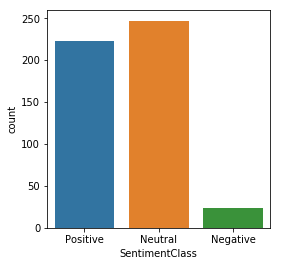

In [12]:
import seaborn as sns
plt.figure(figsize=(4, 4))
sns.countplot(x='SentimentClass', data=A)
plt.show()

### Sample3 - Word Cloud of trending hashtags

In [19]:
import csv
from textblob import TextBlob
import re

def get_twitter_data(csv_fname):  # Open csv file
    #     print('reading data')
    with open(csv_fname, 'r') as f:
        csvreader = csv.reader(f)
        for line in csvreader:
            yield line


def get_hashtags(array_iter):  # Get array holding hashtags
    for i, arr in enumerate(array_iter):
        yield arr[1]
        
def create_wordcloud(array_iter):
    Htag_df = {'Hashtag':[]}
    for i, arr in enumerate(array_iter):
        if i > 0:
            textstring = [m.start() for m in re.finditer('text', arr)]
            indicesstring = [m.start() for m in re.finditer('indices', arr)]
            for j, (k, l) in enumerate(zip(textstring, indicesstring)):
                Htag = arr[k+8:l-4]
                Htag_df['Hashtag'].extend([Htag])
#                 print(Htag)
    return Htag_df

In [20]:
A = create_wordcloud(get_hashtags(get_twitter_data(filename)))
A = pd.DataFrame.from_dict(A)
print('Number of hashtags : ', np.size(A))

Number of hashtags :  1723


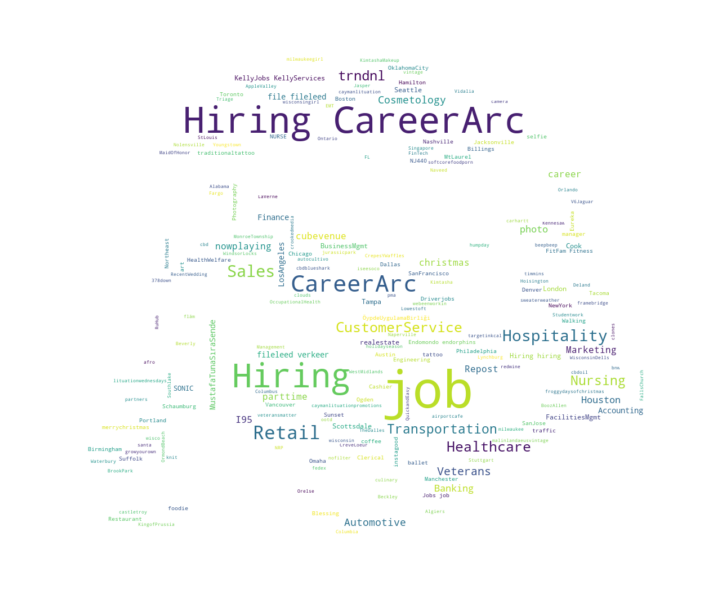

In [21]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

Hashtag_Combined = " ".join(A['Hashtag'].values.astype(str))
Hashtag_Combined = " ".join([word for word in Hashtag_Combined.split()])
Tweet_mask = np.array(Image.open(
    '/Users/seetha/Desktop/Pythoncourse/stormtrooper_mask.png'))

wc = WordCloud(background_color="white", stopwords=STOPWORDS, mask=Tweet_mask)
wc.generate(Hashtag_Combined)

plt.figure(figsize=(12, 12))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()